# Data Processing - Online Session

## Imports

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
import matplotlib.image as mpimg
LOKY_MAX_CPU_COUNT = 4

## Read Dataframe

In [20]:
# Read csv
data = pd.read_csv('data_raw.csv')
print("Shape: " + str(data.shape))

Shape: (41854, 23)


## Columns

### Remove unnecessary columns

In [21]:
# remove column 'ad_displayed' and 'pose_plus_gaze_yaw', 'pose_plus_gaze_pitch' 
data = data.drop(columns=['ad_displayed', 'pose_plus_gaze_yaw','pose_plus_gaze_pitch'])

### Column 'facial_expression'

In [22]:
# Rename 'emotion' column to 'facial_expression'
data = data.rename(columns={'emotion': 'facial_expression'})

# Rename the facial expressions
data['facial_expression'] = data['facial_expression'].replace({
    'sad' : 'tired',
    'anger' : 'frowning',
    'surprise' : 'admired',
    'happy' : 'smilling'
})

mode_by_face = data.groupby('face')['facial_expression'].agg(lambda x: x.mode()[0]).to_dict()
data['facial_expression'] = data.apply(lambda row: mode_by_face[row['face']] if row['facial_expression'] == "unknown" else row['facial_expression'], axis=1) # Replace 'facial_expression' == 'unknown' with the mode of the 'facial_expression' of the respective 'face'

data = data.drop(data.loc[data['facial_expression'] == 'unknown'].index) # Drop rows with 'facial_expression' == 'unknown'

### Column 'face_x1y1x2y2_coordinates'

In [23]:
# Calculate the center of the face (return a tuple (xx,yy))
def calculate_center_face(row):
    x1, y1, x2, y2 = row['face_bbox_x1'], row['face_bbox_y1'], row['face_bbox_x2'], row['face_bbox_y2']
    centro_x = (x1 + x2) / 2
    centro_y = (y1 + y2) / 2
    return pd.Series([centro_x, centro_y], index=['face_center_x', 'face_center_y'])

# Apply the function to the dataframe
data[['face_center_x', 'face_center_y']] = data.apply(calculate_center_face, axis=1)

### Column 'time'

In [24]:

data['datetime'] = pd.to_datetime(data['datetime'])


# Adjust the time of the dataset to match the video
start_video = pd.Timestamp('2024-12-12 17:44:00.000')
start_dataset = data['datetime'].min()
time_difference = start_video - start_dataset
data['datetime'] = data['datetime'] + time_difference


total_time = (data['datetime'].max() - data['datetime'].min()).total_seconds()
video_duration_sec = 38*60+27
scale = video_duration_sec/total_time
data['datetime'] = data['datetime'].min() + (data['datetime'] - data['datetime'].min()) * scale


print("Duration: " + str(data['datetime'].max() - data['datetime'].min()))
print("Start: " + str(data['datetime'].min()))

Duration: 0 days 00:38:26.999999999
Start: 2024-12-12 17:44:00


### Divide dataset in 2

In [25]:
# Divide de dataset in 2 parts:
# 1 - when were 4 people until 21:09
# 2 - when were 2 people

time_limit = data['datetime'].min() + pd.Timedelta(seconds=21*60+9)
data = data[data['datetime'] <= time_limit]
# data2 = data[data['datetime'] > time_limit]

## Modelos Clustering

In [26]:
kmeans = True

### K-Means

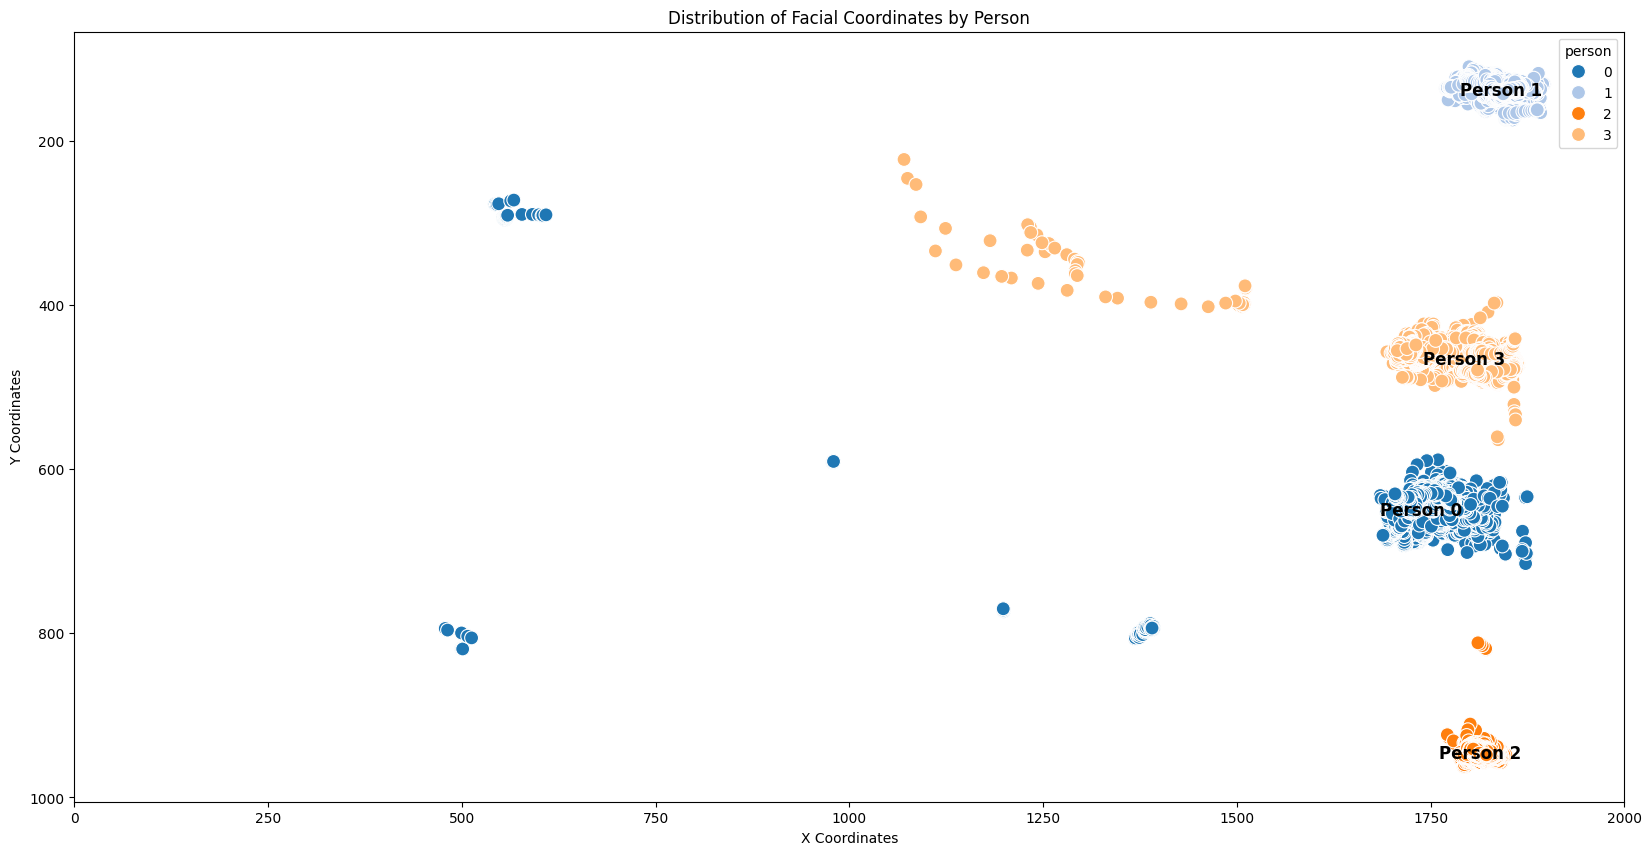

In [27]:
if kmeans:
    
    features = ['face_center_x', 'face_center_y']

    pipeline = Pipeline(steps=[ ('person', KMeans(n_clusters=4, random_state=42)) ])
    pipeline.fit(data[features])
    data['person'] = pipeline['person'].labels_

    plt.figure(figsize=(20, 10))
    sns.scatterplot(x='face_center_x', y='face_center_y', hue='person', data=data, palette='tab20', s=100)

    person_means = data.groupby('person')[['face_center_x', 'face_center_y']].mean().reset_index()
    for _, row in person_means.iterrows():
        plt.text(row['face_center_x'], row['face_center_y'], f"Person {int(row['person'])}", 
                 color='black', fontsize=12, weight='bold', ha='center', va='center')

    plt.title('Distribution of Facial Coordinates by Person')
    plt.xlabel('X Coordinates')
    plt.ylabel('Y Coordinates')
    plt.xlim(0,2000)
    plt.gca().invert_yaxis()
    plt.show()

#### Adjust borders

person
2    6681
3    6673
1    6585
0    6508
Name: count, dtype: int64


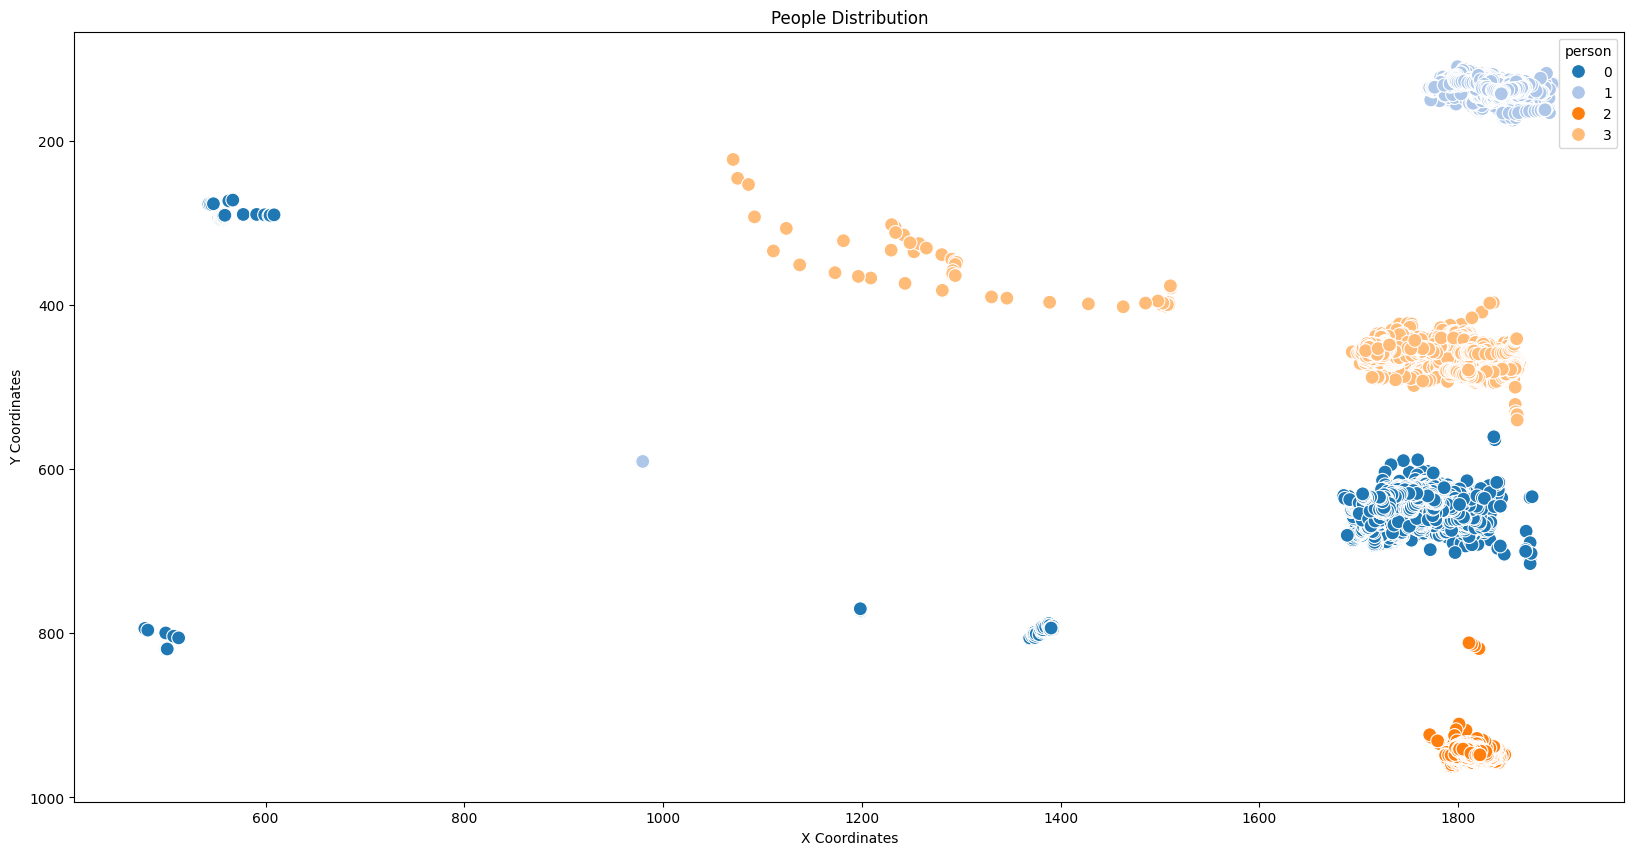

In [28]:
if kmeans: 
    # Group data by face and atributtes to that face the mode of the person in that face
    face_mode = data.groupby('face')['person'].agg(lambda x: x.mode().iloc[0]).to_dict()
    data['person'] = data['face'].map(face_mode)
    print(data['person'].value_counts())

    plt.figure(figsize=(20, 10))
    sns.scatterplot(x='face_center_x', y='face_center_y', hue='person', data=data, palette='tab20', s=100)
    plt.title('People Distribution')
    plt.xlabel('X Coordinates')
    plt.ylabel('Y Coordinates')
    plt.gca().invert_yaxis() 
    plt.show()

## Results

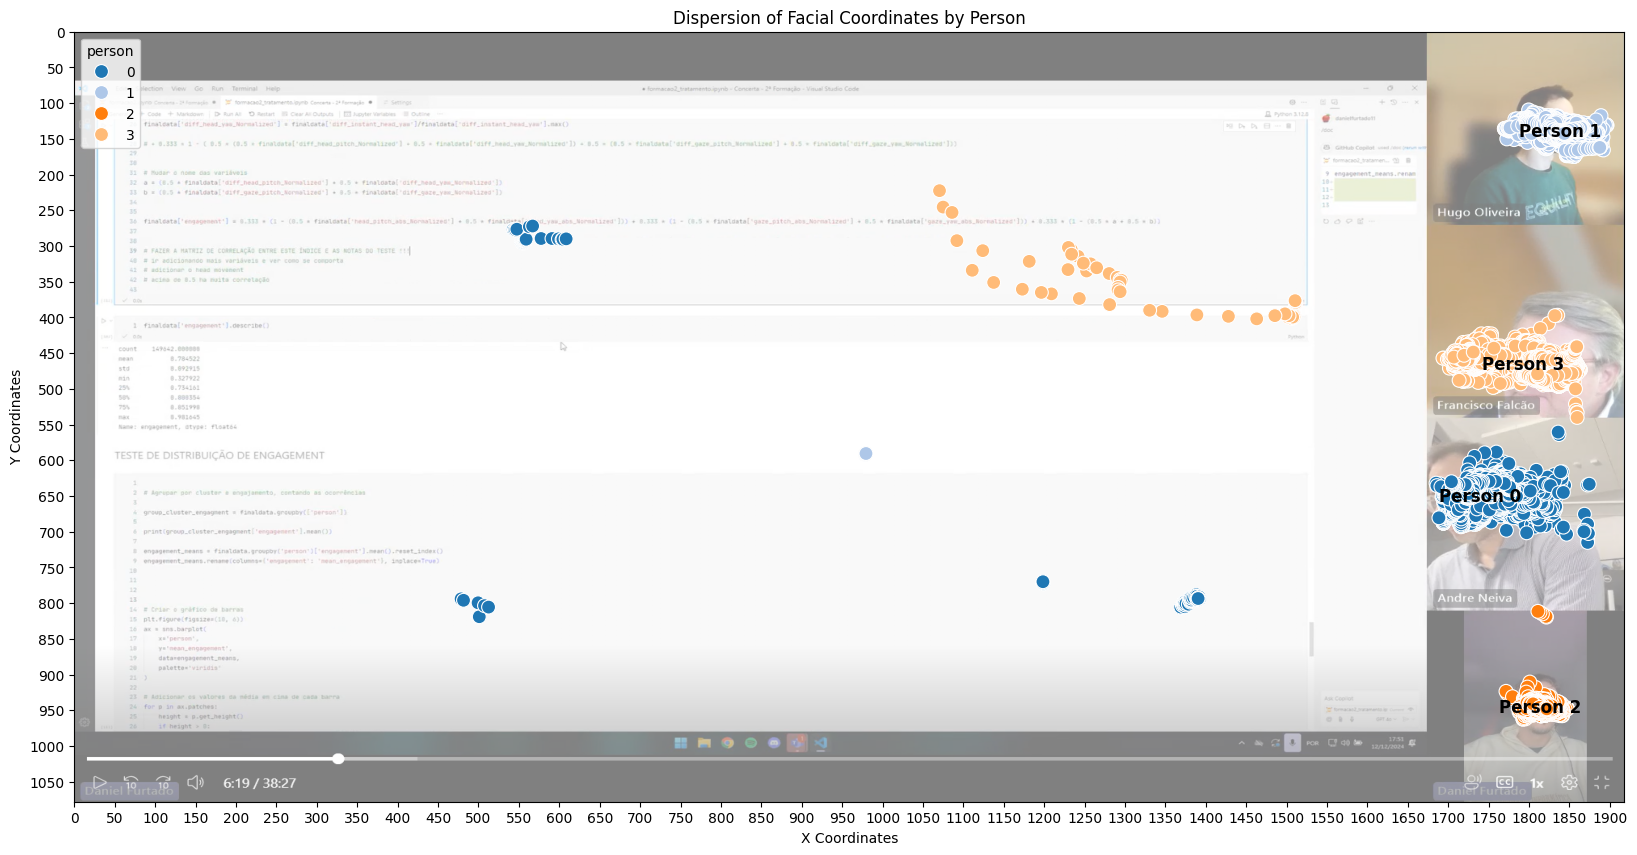

In [29]:
background_image = mpimg.imread('image.png') 
img_height, img_width = background_image.shape[:2]

plt.figure(figsize=(20, 10))
plt.imshow(background_image, extent=[0, img_width, 0, img_height], aspect='auto', alpha=0.5)
sns.scatterplot(x='face_center_x', y='face_center_y', hue='person', data=data, palette='tab20', s=100)
person_means = data.groupby('person')[['face_center_x', 'face_center_y']].mean().reset_index()
for _, row in person_means.iterrows():
    plt.text(row['face_center_x'], row['face_center_y'], f"Person {int(row['person'])}", color='black', fontsize=12, weight='bold', ha='center', va='center')
    
plt.xlim(0, img_width)
plt.ylim(0, img_height)
plt.xticks(np.arange(0, img_width+1, 50))
plt.yticks(np.arange(0, img_height+1, 50)) 
plt.title('Dispersion of Facial Coordinates by Person')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.gca().invert_yaxis()
plt.show()

## Temporal Line for Each Person

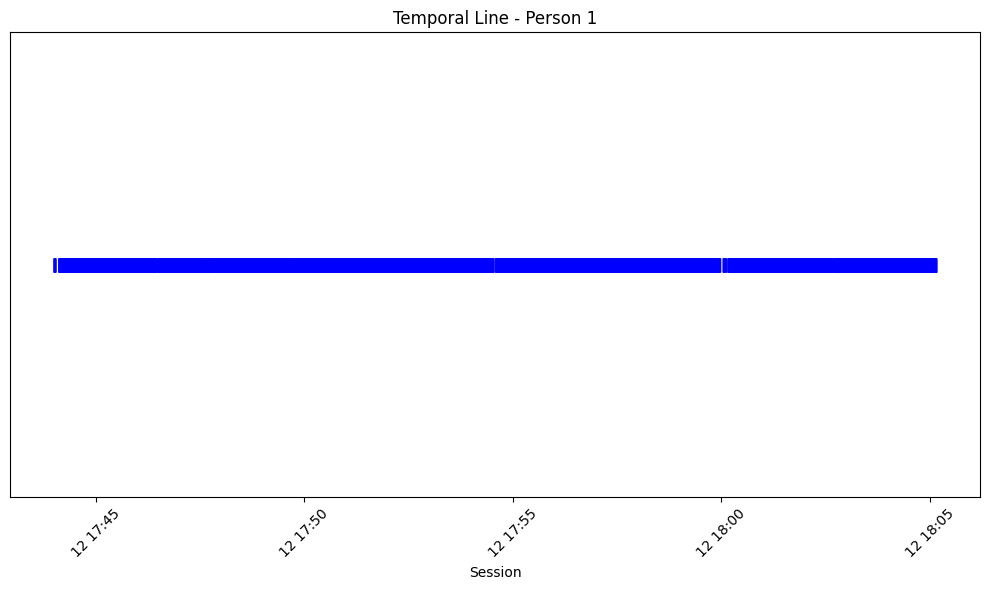

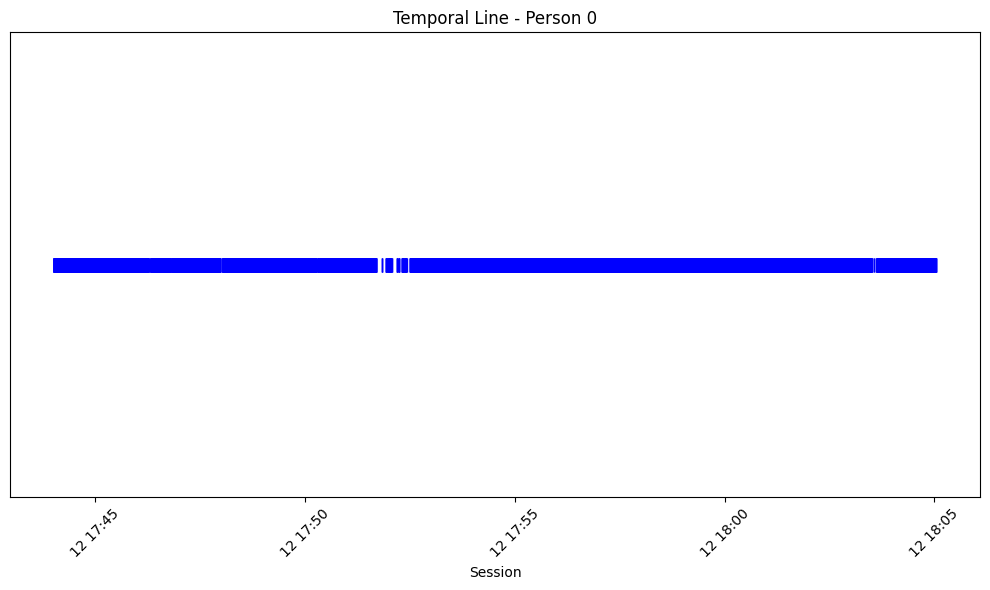

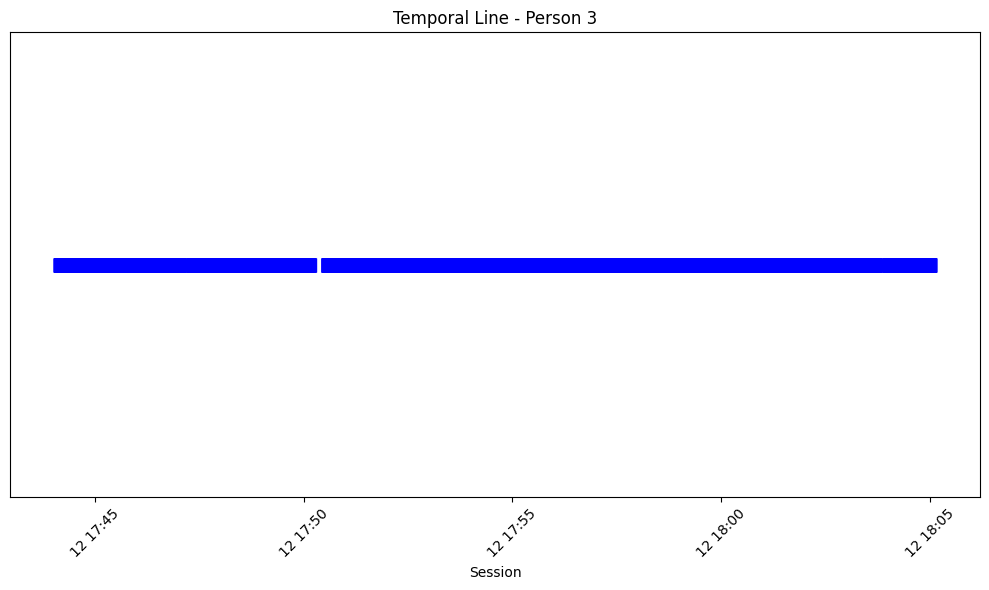

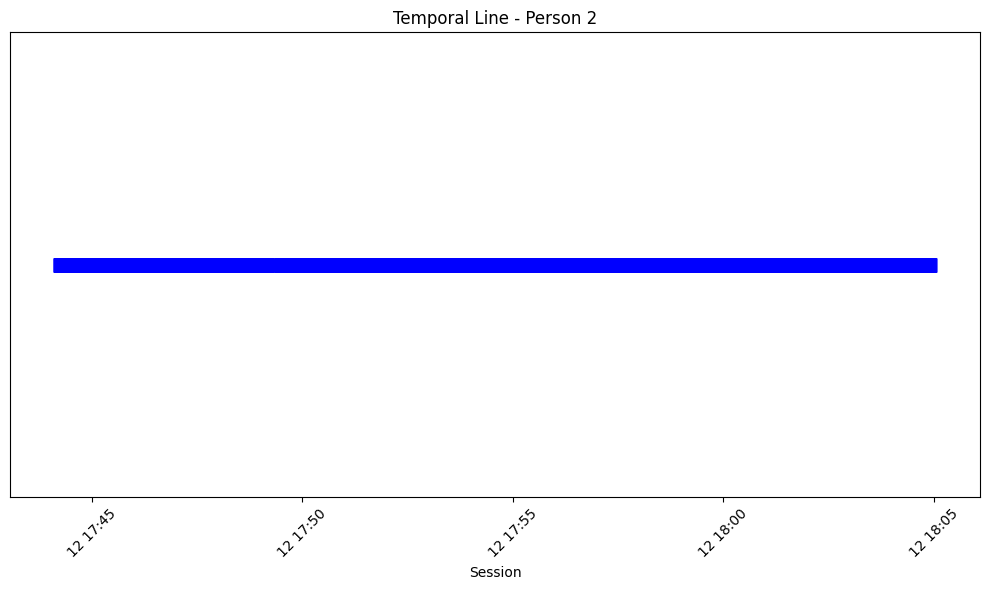

In [30]:
person = data['person'].unique()

for i in person:
    data_person_i = data[data['person'] == i]
    
    plt.figure(figsize=(10, 6))
    plt.plot(data_person_i['datetime'], [1] * len(data_person_i), '|', color='blue', markersize=10)
    plt.title(f'Temporal Line - Person {i}')
    plt.xlabel('Session')
    plt.yticks([]) 
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## Save Dataframe

In [31]:
data.to_csv('data_processed.csv', index=False)